In [143]:
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
from astroML.time_series import lomb_scargle  
# this is the implementation of the actual LS, which 
# redirects to the AstroPy LS 
# https://github.com/astroML/astroML/blob/master/astroML/time_series/periodogram.py 

import sys
sys.path.insert(0, '/Users/chris/GradResearch/SDSS_S82_FP_research/S82analysis/packages/')
import frequencyFunctions as freq
import imp
imp.reload(freq)



<module 'frequencyFunctions' from '/Users/chris/GradResearch/SDSS_S82_FP_research/S82analysis/packages/frequencyFunctions.py'>

# Frequency gridding in action : compare performance of AstroPy, AstroML, EBellm

Here I simulate a time series  $y = A \sin{(2\pi f t )} $, sampled at N random times between $0$ and $t_{max}=100$ : 
    
    t_obs = t_max * np.random.random(N)
    
    y_obs = A*np.sin(2.0 * np.pi *f0 *  t_obs )

In the homoscedastic case, the measurement noise comes from a single Gaussian distribution that has a width $\sigma_{0}$. Thus the errors for each measurement are identical : 
    
    errors = np.ones_like(y_obs) * sigma_0
    
and the noise is 

    noise = np.random.normal(loc=0.0, scale=sigma_0, size=N)
    
In the heteroscedastic case,  the noise for each point comes from  a different Gaussian: 

    errors = 0.1 + 0.1 *np.random.random(N)
    
and the noise is 
    
    noise = np.random.normal(0, dy)
   
I calculate the Power Spectrum on the frequency grid accordingly to one of three prescriptions (AstroML,  AstroPy,  EBellm). 

In [137]:
omega_correction[2]

4.375

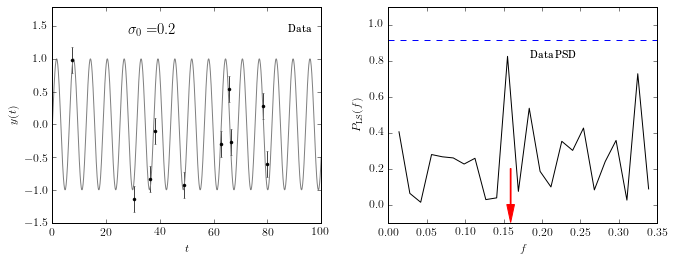

In [158]:
# Simulated time series 
N = 10  # number of samples 
t_max = 100 
A = 1  # input amplitude 
f0 = 1 / (2 * np.pi)  # ordinary frequency of oscillations 
sigma_0 = 0.2 # input standard deviation for the homoscedastic errors 
methods = ['AstroPy','AstroML', 'EBellm'] ##'
method = methods[2]

# underlying well-sampled time series 
t_theory = np.linspace(0, t_max, 1000)
y_theory = A*np.sin(2.0*np.pi * f0 * t )


# simulate the observed (sampled) time series 
t_obs = t_max * np.random.random(N)
y_obs = A*np.sin(2.0 * np.pi *f0 *  t_obs )

# add errors and noise... 
homoscedastic = True
if homoscedastic == True  : 
    # homoscedastic 
    errors = np.ones_like(y_obs) * sigma_0
    noise = np.random.normal(loc=0.0, scale=sigma_0, size=N)
else : 
    # heteroscedastic 
    errors = 0.1 + 0.1 *np.random.random(N)
    noise = np.random.normal(loc=0, scale = errors)

# update the time series 
y_obs += noise 

# ------------------------------------------------------------
# Compute the periodogram : variable grid 
# ------------------------------------------------------------

omega = freq.frequency_grid(t_obs, method = method) 
P_obs = lomb_scargle(t_obs, y_obs, errors, omega)
frequency = omega / (2 * np.pi)

# 10.47 : peak height estimate 
V = (1 / len(y_obs)) * np.sum(y_obs*y_obs) 
P_LS_0 = 1.0 - (sigma_0 ** 2.0 ) / V


# Prepare the figures
plot = True 
if plot == True : 
    fig, ax = plt.subplots(1,2,figsize=(10, 4))
    fig.subplots_adjust(bottom=0.15, hspace=0.35, wspace=0.25,
                        left=0.11, right=0.95)

    ax[0].plot(t_theory, y_theory, '-', c='gray')
    ax[0].errorbar(t_obs, y_obs, errors, fmt='.k', capsize=1, ecolor='#444444')
    ax[0].text(0.96, 0.92, "Data", ha='right', va='top', transform=ax[0].transAxes)
    ax[0].text(0.46, 0.92, r"$\sigma_{0}=$"+r"${0:.1f}$".format(sigma_0), ha='right', va='top', 
               transform=ax[0].transAxes, fontsize=15)
    ax[0].set_ylim(-1.5, 1.8)
    ax[0].set_xlabel('$t$')
    ax[0].set_ylabel('$y(t)$')


    #ax[1].fill(frequency, P_true, fc='gray', ec='gray')
    ax[1].plot(frequency, P_obs, '-', c='black')
    ax[1].text(0.7, 0.8, "Data PSD", ha='right', va='top', transform=ax[1].transAxes)
    ax[1].set_ylim(-0.1, 1.1)
    ax[1].set_xlabel('$f$')
    ax[1].set_ylabel(r'$P_{\rm LS}(f)$')

    # plot the 10.47 P_LS peak height estimate...
    ax[1].axhline(P_LS_0, ls='--')

    # plot the true frequency location
    #ax[1].axvline(f0,ymin=0, ymax=0.2, ls='-', color='red', lw=2)
    ax[1].arrow(f0, 0.2, 0, -0.2, head_width=0.01, head_length=0.1, fc='red', ec='red')  
    plt.savefig('../data_products/Jan_13_time_series_sig_'+str(sigma_0)+'_'+method+'.png')
    plt.show()


## Illustrate the difference between homoscedastic and heteroscedastic errors 

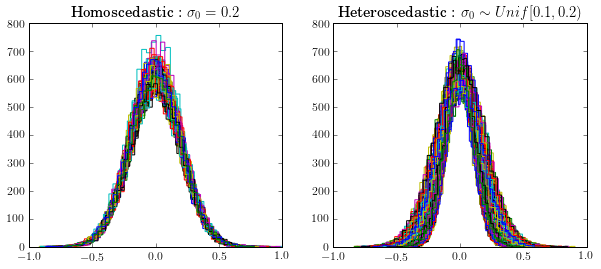

In [151]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
N=10000  # number of points drawn from each Gaussian : for homoscedastic errors, there is one Gaussian, 
# so we draw N_pts ,  but for heteroscedastic errors, we draw  1 point from each Gaussian (which has a different width)
N_pts = 100

# homoscedastic 
errors = np.ones(100, dtype=float) * sigma_0
for sigma in errors : 
    ax[0].hist(np.random.normal(loc=0, scale=sigma,size = N ) , histtype='step', bins=50)

ax[0].set_title('Homoscedastic : '+ r'$\sigma_{0} = 0.2$', fontsize=15)
ax[0].set_xlim(-1,1)

# heteroscedastic 
N=10000
N_pts = 100
errors = 0.1 + 0.1 *np.random.random(N_pts)
for sigma in errors : 
    # each Gaussian has a different width that itself comes from a normal distribution
    ax[1].hist(np.random.normal(loc=0, scale=sigma,size = N ) , histtype='step', bins=50)
    

ax[1].set_title('Heteroscedastic : '+r'$\sigma_{0} \sim Unif[0.1,0.2) $', fontsize=15)
ax[1].set_xlim(-1,1)
plt.savefig('../data_products/Jan_13_error_types_comp.png')

## How many periods do we need ? Experiments from 10/17/16 email  

I generate a simple harmonic time series  $y = A \sin{(2 * np.pi * f * t )} + noise$,  where $noise \sim$ $\mathcal{N}(0,\sigma_{0})$, homoscedastic errors

In [213]:
def simulate_time_series(N=100, A=1.0, N_periods=1, sigma_0=0.2, plot=True, method='AstroPy', save=True): 
    # N :  number of samples 
    # A : input amplitude 
    # N_periods : number of periods 
    # sigma_0 : input standard deviation for the homoscedastic errors

    f0 = 1 / (2 * np.pi)  # ordinary frequency of oscillations 
    
    period  = 1 / f0
    t_max = N_periods * period

    # underlying well-sampled time series 
    t_theory = np.linspace(0, t_max, 1000)
    y_theory = A*np.sin(2.0*np.pi * f0 * t_theory )

    # simulate the observed (sampled) time series 
    t_obs = t_max * np.random.random(N)
    y_obs = A*np.sin(2.0 * np.pi *f0 *  t_obs )

    # add errors and noise... 
    # homoscedastic 
    errors = np.ones_like(y_obs) * sigma_0
    noise = np.random.normal(loc=0.0, scale=sigma_0, size=N)

    y_obs += noise


    # ------------------------------------------------------------
    # Compute the periodogram : variable grid 
    # ------------------------------------------------------------

    omega = freq.frequency_grid(t_obs, method = method) 
    P_obs = lomb_scargle(t_obs, y_obs, errors, omega)
    frequency = omega / (2 * np.pi)

    # Prepare the figures
    if plot == True : 
        fig, ax = plt.subplots(1,2,figsize=(10, 4))
        fig.subplots_adjust(bottom=0.15, hspace=0.35, wspace=0.25,
                            left=0.11, right=0.95)

        ax[0].plot(t_theory, y_theory, '-', c='gray')
        ax[0].errorbar(t_obs, y_obs, errors, fmt='.k', capsize=1, ecolor='#444444')
        
        if max(y_obs) > 0.5 :
            ax[0].text(0.96, 0.92, "Data", ha='right', va='top', transform=ax[0].transAxes)
            ax[0].text(0.46, 0.92, r"$\sigma_{0}=$"+r"${0:.1f}$".format(sigma_0), ha='right', va='top', 
                       transform=ax[0].transAxes, fontsize=15)
        ax[0].set_ylim(-1.5, 1.8)
        ax[0].set_xlabel('$t$')
        ax[0].set_ylabel('$y(t)$')


        #ax[1].fill(frequency, P_true, fc='gray', ec='gray')
        ax[1].plot(frequency, P_obs, '-', c='black')
        ax[1].text(0.7, 0.8, "Data PSD", ha='right', va='top', transform=ax[1].transAxes)
        ax[1].set_ylim(-0.1, 1.1)
        ax[1].set_xlabel('$f$')
        ax[1].set_ylabel(r'$P_{\rm LS}(f)$')


        # plot the true frequency location
        #ax[1].axvline(f0,ymin=0, ymax=0.2, ls='-', color='red', lw=2)
        ax[1].arrow(f0, 0.2, 0, -0.2, head_width=0.01, head_length=0.1, fc='red', ec='red')  

        fig.suptitle('A='+str(A)+', N='+str(N)+', '+str(N_periods)+'  periods, '+method + ' gridding', fontsize=15)
        if save == True : 
            s  ='../data_products/Jan_13_experiment_A-'+str(A)+'_Nperiods-'+str(N_periods)+'_'+method+'.png'
            plt.savefig(s)
            print('Saved as %s'%s)
        plt.show()
        f_max = frequency[P_obs == max(P_obs)]
        print('retrieved frequency = %f'%f_max)

Saved as ../data_products/Jan_13_experiment_A-1.0_Nperiods-1_AstroPy.png


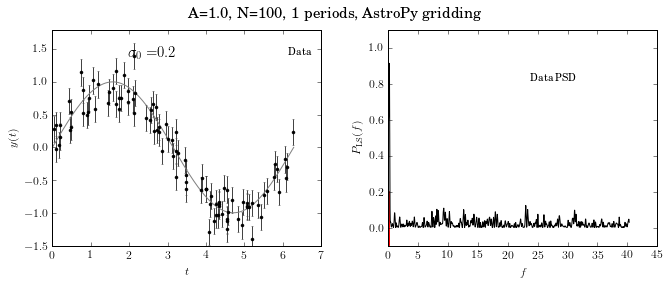

retrieved frequency = 0.145168
Saved as ../data_products/Jan_13_experiment_A-1.0_Nperiods-2_AstroPy.png


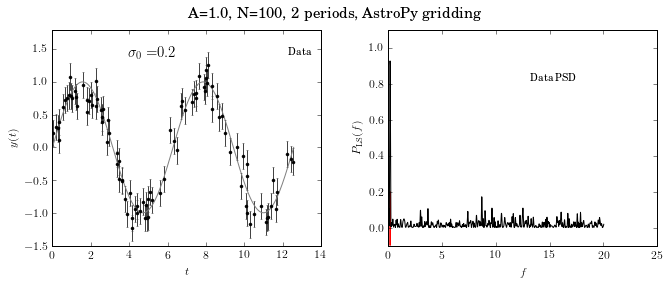

retrieved frequency = 0.152269
Saved as ../data_products/Jan_13_experiment_A-1.0_Nperiods-4_AstroPy.png


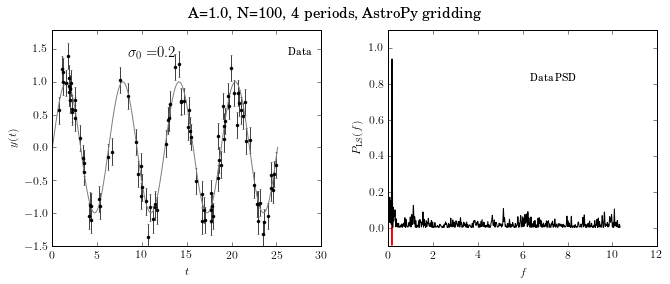

retrieved frequency = 0.161290
Saved as ../data_products/Jan_13_experiment_A-1.0_Nperiods-8_AstroPy.png


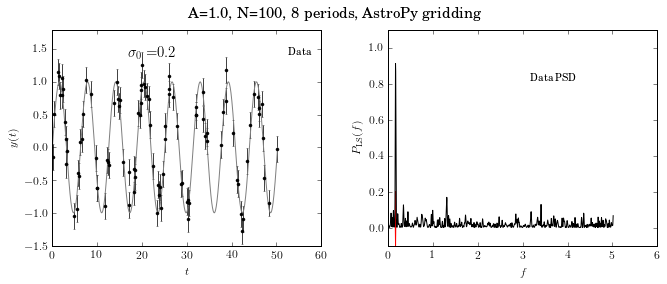

retrieved frequency = 0.158604


In [210]:
# Play with number of periods with AstroPy gridding 
for N_periods in [1,2,4,8]:
    simulate_time_series(N_periods = N_periods)

Saved as ../data_products/Jan_13_experiment_A-1.0_Nperiods-1_AstroML.png


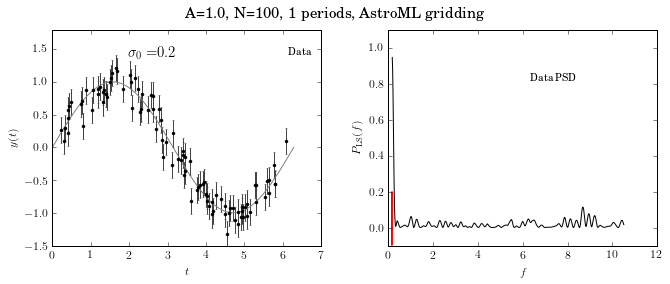

retrieved frequency = 0.171367
Saved as ../data_products/Jan_13_experiment_A-1.0_Nperiods-2_AstroML.png


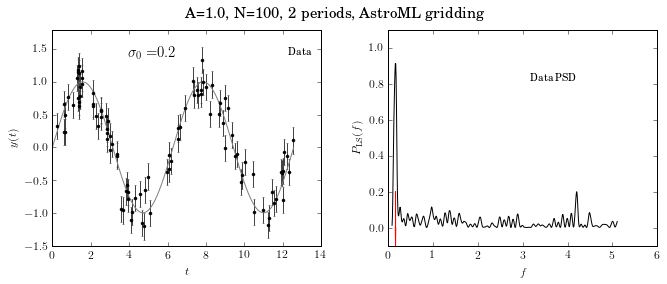

retrieved frequency = 0.154839
Saved as ../data_products/Jan_13_experiment_A-1.0_Nperiods-4_AstroML.png


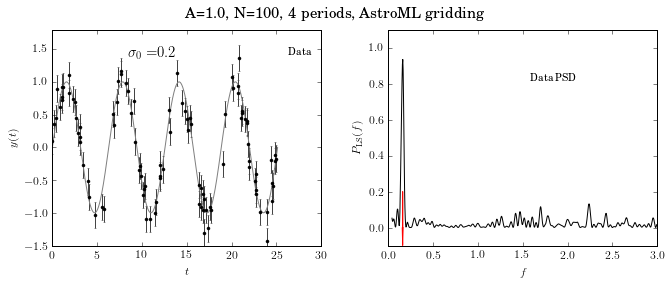

retrieved frequency = 0.160243
Saved as ../data_products/Jan_13_experiment_A-1.0_Nperiods-8_AstroML.png


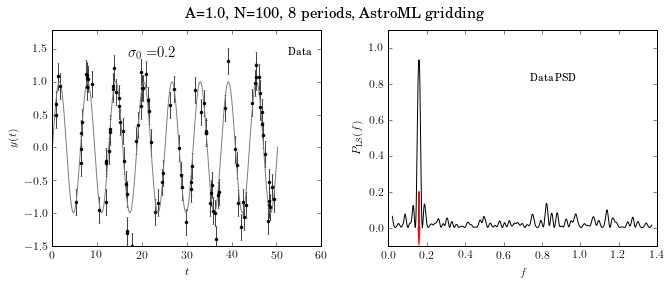

retrieved frequency = 0.160178


In [211]:
# Play with number of periods with AstroML gridding 
for N_periods in [1,2,4,8]:
    simulate_time_series(N_periods = N_periods, method='AstroML')

Saved as ../data_products/Jan_13_experiment_A-0.01_Nperiods-8_AstroML.png


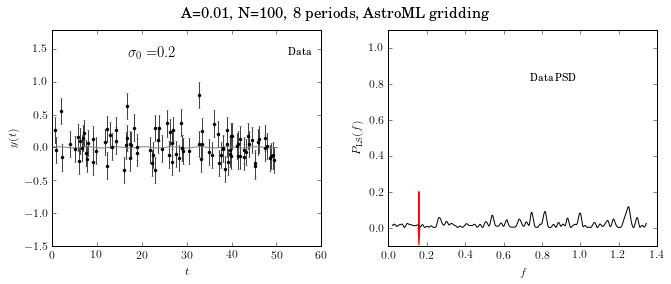

retrieved frequency = 1.250315
Saved as ../data_products/Jan_13_experiment_A-0.1_Nperiods-8_AstroML.png


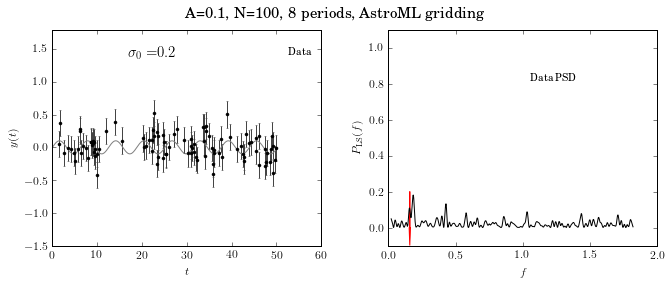

retrieved frequency = 0.184254
Saved as ../data_products/Jan_13_experiment_A-0.7_Nperiods-8_AstroML.png


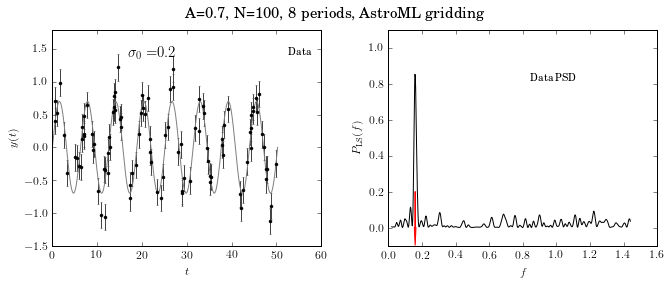

retrieved frequency = 0.158170
Saved as ../data_products/Jan_13_experiment_A-1.0_Nperiods-8_AstroML.png


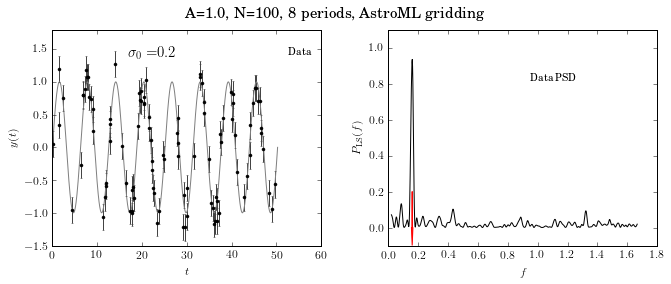

retrieved frequency = 0.159689


In [216]:
# Play with Amplitude with AstroML gridding 
for Amplitude in [0.01, 0.1, 0.7, 1.0 ]:
    simulate_time_series(N_periods = 8, A = Amplitude, method='AstroML')

Basically, these simulations show that we need amplitude larger than the input noise, and that we need more than one period (ideally), with many points.  In general, it shows that the LS method is not best for detecting  variability..